# Neural Network From Scratch With Numpy

### CA4 @ AI Course

*Full Name:* ...

*SID:* ...

In [1]:
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.data import get_MNIST_data, get_normalized_MNIST_data, get_california_housing_data, get_california_housing_normalized__data
from builtins import range
import numpy as np
import matplotlib.pyplot as plt
from utils.solver import *
import pandas as pd
from sklearn.datasets import fetch_california_housing

from termcolor import colored

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.cmap'] = 'gray'

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

def cprint(text : str, color : str = "yellow") -> None:
    print(colored(text, color))

In [3]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    SHAPE = x.shape[0]
    D = np.prod(x.shape[1:])
    x_reshaped = x.reshape(SHAPE, D)
    return np.dot(x_reshaped, w) + b, (x, w, b)    

In [5]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """    
    x,w,b = cache

    SHAPE = x.shape[0]
    D = np.prod(x.shape[1:])
    x_reshaped = x.reshape(SHAPE, D)

    dx = np.dot(dout, w.T).reshape(x.shape)
    dw = np.dot(x_reshaped.T, dout)
    db = np.sum(dout, axis=0)

    return dx,dw,db

In [7]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    return np.maximum(0, x), x

In [9]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    return dout * (cache > 0)

In [11]:
def sigmoid_forward(x):
    """
    Computes the forward pass for a layer of Sigmoid.

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = 1 / (1 + np.exp(-x))
    return out, out

In [13]:
def sigmoid_backward(dout, cache):
    """
    Computes the backward pass for a layer of Sigmoid.

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    return dout * cache * (1 - cache)


In [15]:
def affine_relu_forward(x, w, b):
    """
    Convenience layer that performs an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass# Test the sigmoid_backward function
    """
    affine_out, affine_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(affine_out)
    cache = (affine_cache, relu_cache)
    return out, cache

In [16]:
def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    
    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (fc_cache, relu_cache)
      
    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    fc_cache, relu_cache = cache
    drelu = relu_backward(dout, relu_cache) 
    dx, dw, db = affine_backward(drelu, fc_cache)
    return dx, dw, db

In [18]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    shifted_logits = x - np.max(x, axis=1, keepdims=True) 
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z) 
    probs = np.exp(log_probs)
    N = x.shape[0] 
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy() 
    dx[np.arange(N), y] -= 1 
    dx /= N

    return loss, dx

In [46]:
def mse_loss(x, y):
    """
    Computes the loss and gradient for MSE loss.

    Inputs:
    - x: Input data, of shape (N,) where x[i] is the predicted vector for 
        the ith input.
    - y: Vector of target values, of shape (N,) where y[i] is the target value
        for the ith input.

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    y = y.reshape(-1, 1)
    MSE = np.mean((x - y) ** 2)
    dx = (2 / x.shape[0]) * (x - y)
    return MSE,dx

In [26]:
class FullyConnectedNet(object):
    """Class for a multi-layer fully connected neural network.

    Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function for a classification problem or the MSE loss function for 
    a regression problem. 
    For a network with L layers, the architecture will be

    {affine - relu} x (L - 1) - affine - softmax/mse

    where The {...} block is
    repeated L - 1 times.

    Learnable parameters are stored in the self.params dictionary and will be learned
    using the Solver class.
    """

    def __init__(
        self,
        category,
        hidden_dims,
        input_dim=784,
        output_dim=10,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
    ):
        """Initialize a new FullyConnectedNet.

        Inputs:
        - category: The type of the problem. Valid values are "classification",
            "regression".
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - output_dim: An integer giving the number of classes to classify. It
            is 1 for a regression problem.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
            this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.
        """
        self.category = category
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        layer_input_dim = input_dim

        for i, hidden_dim in enumerate(hidden_dims):
            self.params[f'W{i+1}'] = np.random.normal(0, weight_scale, (layer_input_dim, hidden_dim))
            self.params[f'b{i+1}'] = np.zeros(hidden_dim)
            layer_input_dim = hidden_dim

        self.params[f'W{self.num_layers}'] = np.random.normal(0, weight_scale, (layer_input_dim, output_dim))
        self.params[f'b{self.num_layers}'] = np.zeros(output_dim)

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """Compute loss and gradient for the fully connected net.
        
        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels / target values, of shape (N,). y[i] gives the 
            label / target value for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return
        scores for a classification problem or the predicted_values for 
        a regression problem:
        - out: Array of shape (N, C) / (N, ) giving classification scores / predicted values, where 
        scores[i, c] is the classification score for X[i] and class c / predicted_values[i]
        is the predicted value for X[i].
            

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
            names to gradients of the loss with respect to those parameters.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"
        caches = []
        out = X

        for i in range(self.num_layers - 1):
            W, b = self.params[f'W{i+1}'], self.params[f'b{i+1}']
            out, cache = affine_relu_forward(out, W, b)
            caches.append(cache)

        W, b = self.params[f'W{self.num_layers}'], self.params[f'b{self.num_layers}']
        out1, cache = affine_forward(out, W, b)
        caches.append(cache)


        if mode == "test":
            return out1

        loss, dx = 0.0, None
        if self.category == "classification":
            loss, dx = softmax_loss(out1, y)
        elif self.category == "regression":
            loss, dx = mse_loss(out1, y)

        for i in range(self.num_layers):
            W = self.params[f'W{i+1}']
            loss += 0.5 * self.reg * np.sum(W ** 2)

        grads = {}
        for i in range(self.num_layers - 1, -1, -1):
            if i == self.num_layers - 1:
              dx, dw, db = affine_backward(dx, caches[i])
            else:
                dx, dw, db = affine_relu_backward(dx, caches[i])

            grads[f'W{i+1}'] = dw + self.reg * self.params[f'W{i+1}']
            grads[f'b{i+1}'] = db

        return loss, grads

In [22]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        "classification",
        [H1, H2],
        input_dim=D,
        output_dim=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.4839894098713283e-07
W2 relative error: 2.2120479317702687e-05
W3 relative error: 3.527252851540647e-07
b1 relative error: 5.376386228531692e-09
b2 relative error: 2.085654124402131e-09
b3 relative error: 5.7957243458479405e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.904541941902138e-09
W2 relative error: 6.86942277940646e-08
W3 relative error: 2.131129848945024e-08
b1 relative error: 1.4752428222134868e-08
b2 relative error: 1.7223750761525226e-09
b3 relative error: 1.5702714832602802e-10


In [29]:
def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.
    Inputs:
    - w: A numpy array giving the current weights.
    - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
    - config: A dictionary containing hyperparameter values such as learning
    rate, momentum.

    Returns:
      - next_w: The next point after the update.
      - config: The config dictionary to be passed to the next iteration of the
        update rule.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces sgd_momentum to stochastic gradient descent.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("momentum", 0.9)
    v = config.get("velocity", np.zeros_like(w))

    next_w = None
    v = config["momentum"] * v - config["learning_rate"] * dw
    next_w = w + v  

    config["velocity"] = v

    return next_w, config

In [31]:
X_train, y_train, X_val, y_val, X_test, y_test = get_MNIST_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


In [33]:
def vis():
    classes = list(range(10))
    num_classes = len(classes)
    samples_per_class = 7
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].reshape((28, 28)))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
# vis()

In [34]:
X_train, X_val, X_test = get_normalized_MNIST_data(X_train, X_val, X_test)

In [36]:
MNIST_best_model = None

data = {
    'X_train': X_train,
    'y_train': y_train.astype(int),
    'X_val': X_val,
    'y_val': y_val.astype(int),
    'X_test': X_test,
    'y_test': y_test.astype(int)
    }

model = FullyConnectedNet(
    # TODO 
    category="classification",
    hidden_dims=[512, 256, 128],
    # input_dim=28*28,
    # output_dim=10,
    reg=0,
    # weight_scale=1e-2,
    dtype=np.float64
)
solver = Solver(model, data,
                update_rule=sgd_momentum,
                optim_config={
                  'learning_rate': 0.005
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=16,
                print_every=2000)
solver.train()

MNIST_solver = solver
MNIST_best_model = model

(Iteration 1 / 31250) loss: 2.302620
(Epoch 0 / 10) train acc: 0.084000; val_acc: 0.107300
(Iteration 2001 / 31250) loss: 0.336430
(Epoch 1 / 10) train acc: 0.943000; val_acc: 0.939200
(Iteration 4001 / 31250) loss: 0.007927
(Iteration 6001 / 31250) loss: 0.028937
(Epoch 2 / 10) train acc: 0.973000; val_acc: 0.964100
(Iteration 8001 / 31250) loss: 0.006351
(Epoch 3 / 10) train acc: 0.983000; val_acc: 0.967100
(Iteration 10001 / 31250) loss: 0.000834
(Iteration 12001 / 31250) loss: 0.003926
(Epoch 4 / 10) train acc: 0.987000; val_acc: 0.970200
(Iteration 14001 / 31250) loss: 0.014504
(Epoch 5 / 10) train acc: 0.986000; val_acc: 0.971300
(Iteration 16001 / 31250) loss: 0.001731
(Iteration 18001 / 31250) loss: 0.107298
(Epoch 6 / 10) train acc: 0.988000; val_acc: 0.973800
(Iteration 20001 / 31250) loss: 0.000268
(Epoch 7 / 10) train acc: 0.998000; val_acc: 0.973900
(Iteration 22001 / 31250) loss: 0.002061
(Iteration 24001 / 31250) loss: 0.000302
(Epoch 8 / 10) train acc: 0.996000; val_acc

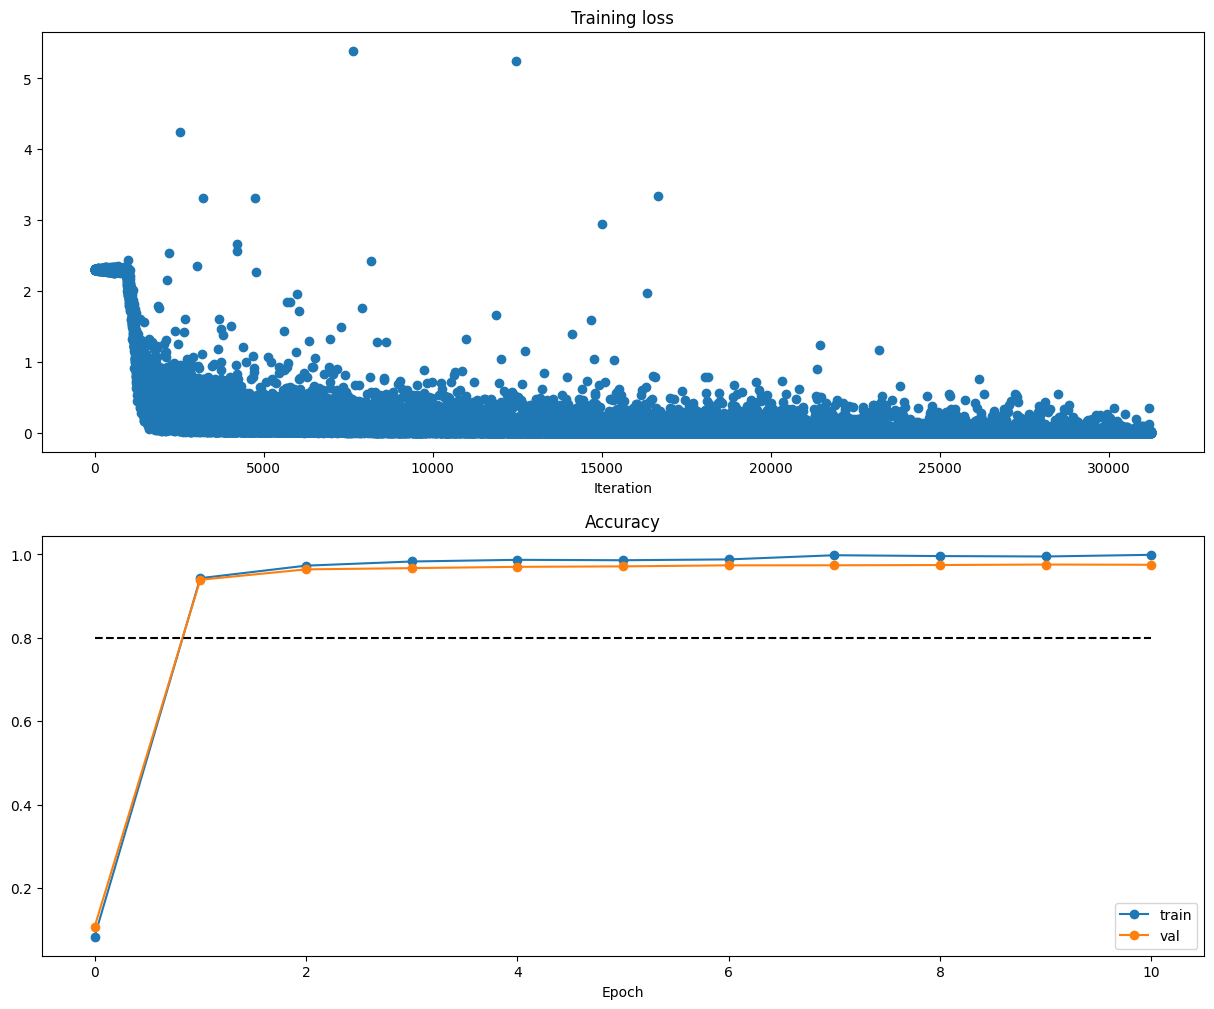

In [38]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(MNIST_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(MNIST_solver.train_acc_history, '-o', label='train')
plt.plot(MNIST_solver.val_acc_history, '-o', label='val')
plt.plot([0.8] * len(MNIST_solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [39]:
y_test_pred = np.argmax(MNIST_best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(MNIST_best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.9757
Test set accuracy:  0.975


In [41]:
california_housing = fetch_california_housing(as_frame=True)
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [42]:
X_train, y_train, X_val, y_val, X_test, y_test = get_california_housing_data()
print('Train data shape: ', X_train.shape)
print('Train target values shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation target values shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test target values shape: ', y_test.shape)

Train data shape:  (15640, 8)
Train target values shape:  (15640,)
Validation data shape:  (2500, 8)
Validation target values shape:  (2500,)
Test data shape:  (2500, 8)
Test target values shape:  (2500,)


In [44]:
X_train, X_val, X_test = get_california_housing_normalized__data(X_train, X_val, X_test)

In [68]:
california_housing_best_model = None
data = {
    'X_train': X_train,
    'y_train': y_train.astype(int),
    'X_val': X_val,
    'y_val': y_val.astype(int),
    'X_test': X_test,
    'y_test': y_test.astype(int)
    }

model = FullyConnectedNet(
    # TODO
    category="regression",
    hidden_dims=[100, 50, 25],
    input_dim=X_train.shape[1],
    output_dim=1,  # Single output for regression
    # reg=0.001,
    # weight_scale=0.001,
    dtype=np.float64
)
solver = Solver(model, data,
                update_rule=sgd_momentum,
                optim_config={
                  'learning_rate': 0.001,
                },
                lr_decay=0.99,
                num_epochs=100, batch_size=4,
                print_every=1000)
solver.train()

california_housing_solver = solver
california_housing_best_model = model

(Iteration 1 / 391000) loss: 2.749999
(Epoch 0 / 100) train RMS error: 1.898562; val RMS error: 2.609672
(Iteration 1001 / 391000) loss: 0.250028
(Iteration 2001 / 391000) loss: 0.746827
(Iteration 3001 / 391000) loss: 0.724323
(Epoch 1 / 100) train RMS error: 1.136658; val RMS error: 1.528334
(Iteration 4001 / 391000) loss: 1.210780
(Iteration 5001 / 391000) loss: 4.294456
(Iteration 6001 / 391000) loss: 0.621003
(Iteration 7001 / 391000) loss: 1.199850
(Epoch 2 / 100) train RMS error: 1.232643; val RMS error: 1.507468
(Iteration 8001 / 391000) loss: 2.749877
(Iteration 9001 / 391000) loss: 0.229404
(Iteration 10001 / 391000) loss: 0.758478
(Iteration 11001 / 391000) loss: 1.253041
(Epoch 3 / 100) train RMS error: 1.282082; val RMS error: 1.552593
(Iteration 12001 / 391000) loss: 4.189318
(Iteration 13001 / 391000) loss: 3.743704
(Iteration 14001 / 391000) loss: 3.294055
(Iteration 15001 / 391000) loss: 0.693546
(Epoch 4 / 100) train RMS error: 1.248936; val RMS error: 1.503033
(Itera

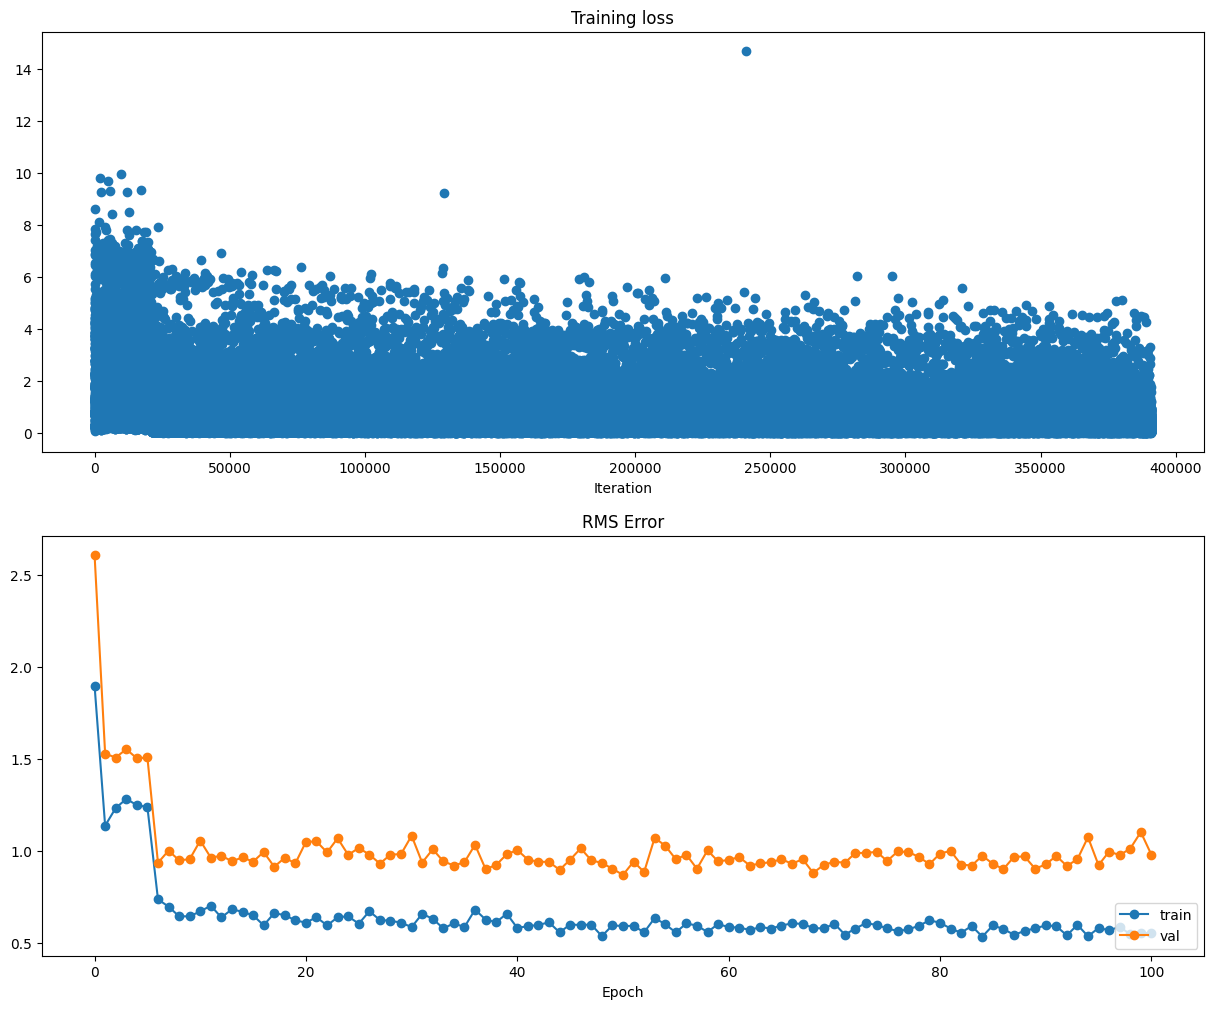

In [69]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(california_housing_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('RMS Error')
plt.plot(california_housing_solver.train_acc_history, '-o', label='train')
plt.plot(california_housing_solver.val_acc_history, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()